In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
sns.set()

In [9]:
# import fileinput

# merge 4 files in 1

# filelist = ['tom_1.txt', 'tom_2.txt','tom_3.txt','tom_4.txt']
# with open('output.txt', 'w', encoding='utf-8') as f:
#     for line in fileinput.input(filelist):
#         f.write(line)

with open("Лекции/4._Случайные_марковские_процессы/4. Случайные_марковские_процессы/output.txt", 'r') as f:
    text = f.read().lower()

In [10]:
text = re.sub(r'[^а-я\s]','', text)
text = re.sub(r'\s+', ' ', text) # удаляем лишние пробелы
print(text[:100])

 лев толстой война и мир том том часть первая часть орая часть третья том лев николаевич толстой вой


In [12]:
RUSSIAN = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя '
n = len(RUSSIAN)
POS = {l: i for i, l in enumerate(RUSSIAN)}

In [13]:
probabilities = np.zeros((len(RUSSIAN), len(RUSSIAN)))
probabilities.shape

(34, 34)

/tmp/ipykernel_27425/4078042968.py:4: RuntimeWarning: invalid value encountered in divide
  probabilities = (probabilities / probabilities.sum(axis=1)[:, None])


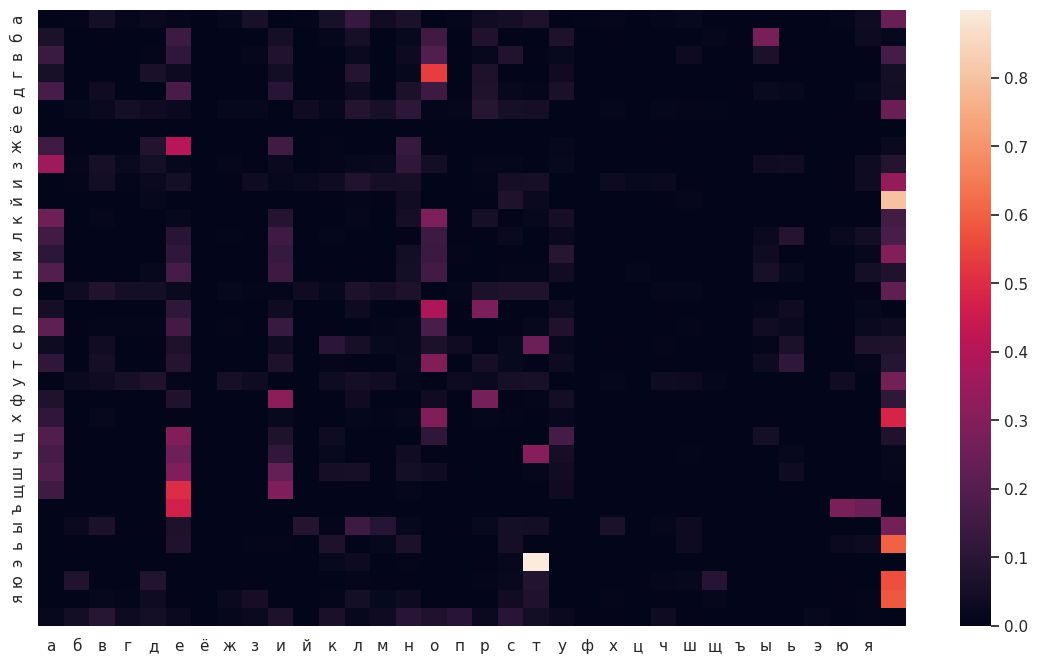

In [14]:
for cp, cn in zip(text[:-1], text[1:]):
    probabilities[POS[cp], POS[cn]] += 1

probabilities = (probabilities / probabilities.sum(axis=1)[:, None])
probabilities[np.isnan(probabilities)] = 0 # буква Ё не встретачается вообще
df = pd.DataFrame(probabilities, index=(c for c in RUSSIAN), columns=(c for c in RUSSIAN))

plt.figure(figsize=(14,8))
sns.heatmap(df)
plt.show()

In [15]:
p_freq = text.count('п') / len(text)
print('Вероятность, что мы встретим букву п', p_freq)

p_idx = RUSSIAN.index('п')
r_idx = RUSSIAN.index('р')
print(r_idx)

Вероятность, что мы встретим букву п 0.02207200887675845
17


In [16]:
prob = 0
for c2 in range(n):
    for c3 in range(n):
        prob += (
            p_freq *  # P(C1 = 'п')
            probabilities[p_idx, c2] *  # P(C2 | C1 = 'п')
            probabilities[c2, c3] *     # P(C3 | C2)
            probabilities[c3, r_idx]    # P(C4 = 'р' | C3)
        )

print(f"вероятность встретить строку из четырёх символов, которая начинается на букву «П» и заканчивается на букву «Р».: {prob:.6f}")

вероятность встретить строку из четырёх символов, которая начинается на букву «П» и заканчивается на букву «Р».: 0.000715


In [17]:
import random

# Start with 'б'
word = ['б']
current_idx = RUSSIAN.index('б')

# Generate 7 more characters
for _ in range(7):
    probs = probabilities[current_idx]
    # Убираем пробел и случайно выбирам следующую букву с учетом веротяностей
    next_char = random.choices(RUSSIAN[:-1], weights=probs[:-1], k=1)[0]
    word.append(next_char)
    current_idx = RUSSIAN.index(next_char)

# Join characters into a word
generated_word = ''.join(word)
print(f"Генерируем слово: {generated_word}")

Генерируем слово: бымизяло


In [74]:
# 6 
# HMM - Hidden Markov Model
# Choose time series from previous task and apply HMM

from hmmlearn.hmm import GaussianHMM

df = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
df['Week'] = df['Week'].apply(lambda x: pd.to_datetime(x + '-1', format='%Y-W%U-%w'))
df.set_index('Week', inplace=True)
series = df['Close']
df.head()

,Close
Week,
1971-07-05,890.19
1971-07-12,901.80
1971-07-19,888.51
1971-07-26,887.78
1971-08-02,858.43


In [77]:
series_values = series.values.reshape(-1,1) 

# Fit HMM with 3-8 hidden states
model = GaussianHMM(n_components=8, covariance_type="full", n_iter=100, random_state=42)
model.fit(series_values)

# Evaluate: log-likelihood
log_likelihood = model.score(series_values)
print(f"HMM Log-Likelihood: {log_likelihood:.2f}")

# Decode hidden states
hidden_states = model.predict(series_values)
print(f"First 10 Hidden States: {hidden_states[:10]}")

# Optional: Visualize states
df['Hidden State'] = hidden_states
print(df.head())

HMM Log-Likelihood: -731.53
First 10 Hidden States: [6 6 6 6 2 2 2 2 0 0]
             Close  Hidden State
Week                            
1971-07-05  890.19             6
1971-07-12  901.80             6
1971-07-19  888.51             6
1971-07-26  887.78             6
1971-08-02  858.43             2


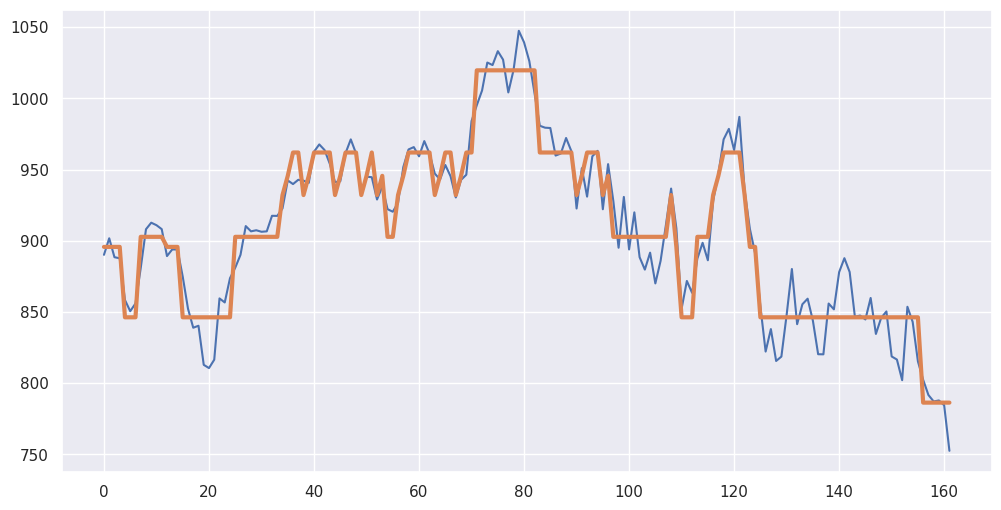

In [84]:
# Если раскоментировать, то каждый раз моедль будет инициализироваться по разному и строить новый график

# model = GaussianHMM(n_components=8,
#                         covariance_type="diag",
#                         n_iter=100)
# model.fit(series_values)


labels = model.predict(series_values)
means = np.zeros_like(series_values)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]
    
plt.figure(figsize=(12, 6))
plt.plot(series_values)
plt.plot(means, linewidth=3)

split_date: 1974-05-27 00:00:00
RMSE = 51.02099604656885


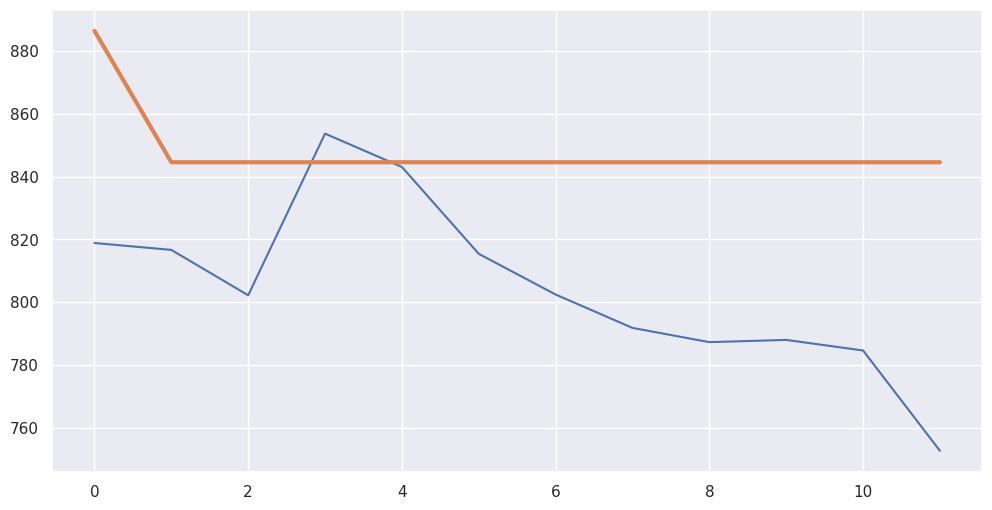

In [111]:
from sklearn.metrics import root_mean_squared_error

split_date = series[-12:].index[0]
print(f'split_date: {split_date}')

series_train = series[:split_date]
series_test = series[split_date:]

series_train = series_train.values.reshape(-1,1)
series_test = series_test.values.reshape(-1,1)

model = GaussianHMM(n_components=8, covariance_type="full", n_iter=100, random_state=42)
model.fit(series_train)


labels = model.predict(series_test)
means = np.zeros_like(series_test)
for i in range(model.n_components):
    means[labels == i] = model.means_[i]

plt.figure(figsize=(12, 6))
plt.plot(series_test)
plt.plot(means, linewidth=3)

rmse = root_mean_squared_error(series_test,means)
print(f'RMSE = {rmse}')